In [50]:
%pip install deeptrack==0.11.3

import numpy as np
import deeptrack as dt
import matplotlib.pyplot as plt
plt.style.use('default')

Note: you may need to restart the kernel to use updated packages.


In [51]:
IMAGE_SIZE = 128
SAMPLE_THICKNESS = 300

Om man väljer partikelradien till en meter, varför ser det normalt ut?

In [52]:
particle = dt.MieSphere(
    position = (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2, #lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * IMAGE_SIZE - IMAGE_SIZE / 2,
    z = lambda: np.random.uniform(-SAMPLE_THICKNESS / 2, SAMPLE_THICKNESS / 2),
    radius = lambda: (1e-7 + 3e-7 * np.random.rand()),
    refractive_index = lambda: np.random.rand() * 0.3 + 1.37,
    L = 8,
    position_unit = 'pixel'
)

In [53]:
HC = dt.HorizontalComa(coefficient= lambda c1: c1, c1 = 0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient= lambda c2: c2, c2 = 0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner

CROP = dt.Lambda(crop, pupil_radius = 23)

optics = dt.Brightfield(
    NA = 1.3,
    resolution = 1.13e-6,
    wavelength= 635e-9,
    aperture_angle= 53.7 * 2 * np.pi / 360,
    polarization_angle= lambda: np.random.rand() * 2 * np.pi,
    magnification= 10,
    output_region= (0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding= (64,) * 4,
    return_field = True,
    pupil = HC + VC + CROP
)

In [54]:
real_noise = dt.Gaussian(
    mu = 0,
    sigma = lambda level: np.random.rand() * 0.02
)

noise = real_noise + dt.Gaussian(
    mu = 0,
    sigma = lambda real_sigma: real_sigma * 0.03j,
    real_sigma = real_noise.sigma
)

def func():
    def inner(image):
        image = (image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner

complex_to_float = dt.Lambda(func)

In [55]:
dataset = optics(particle**1 + noise) + complex_to_float

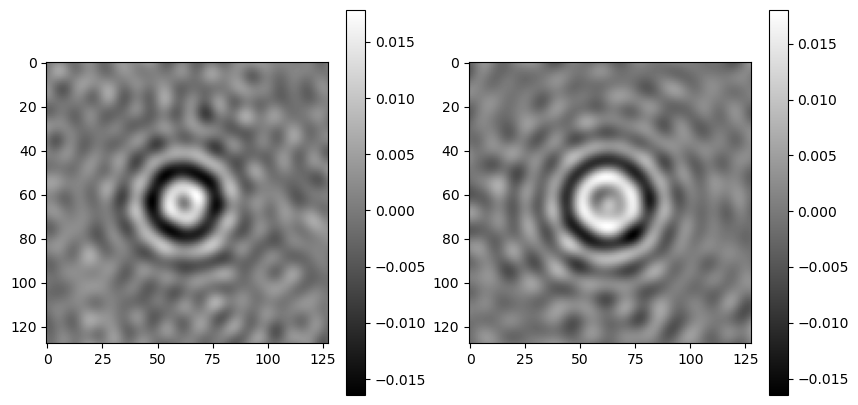

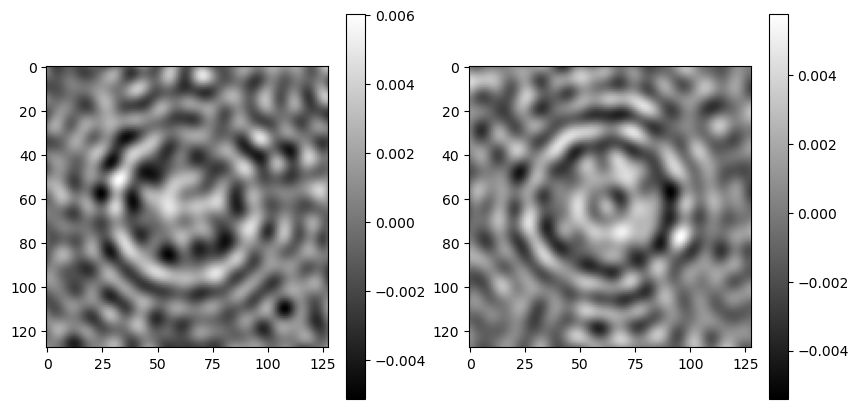

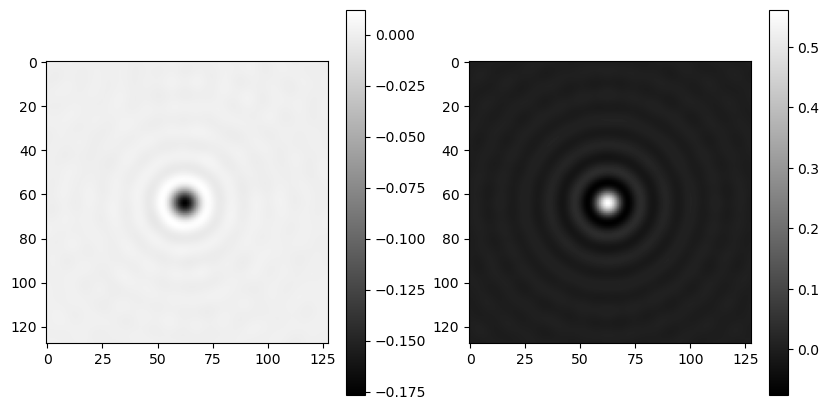

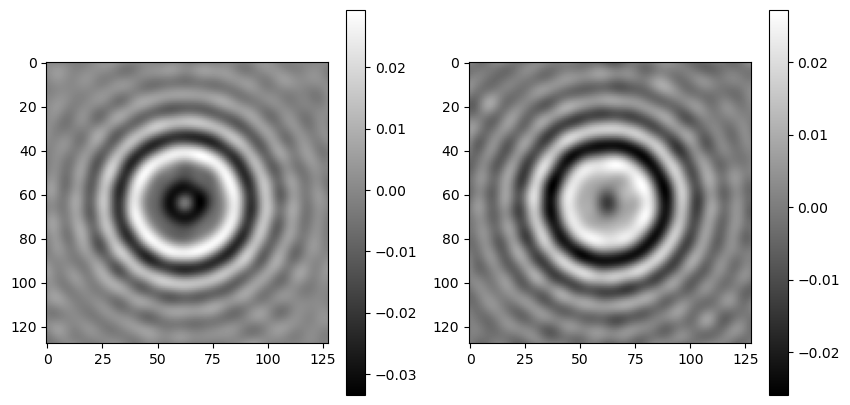

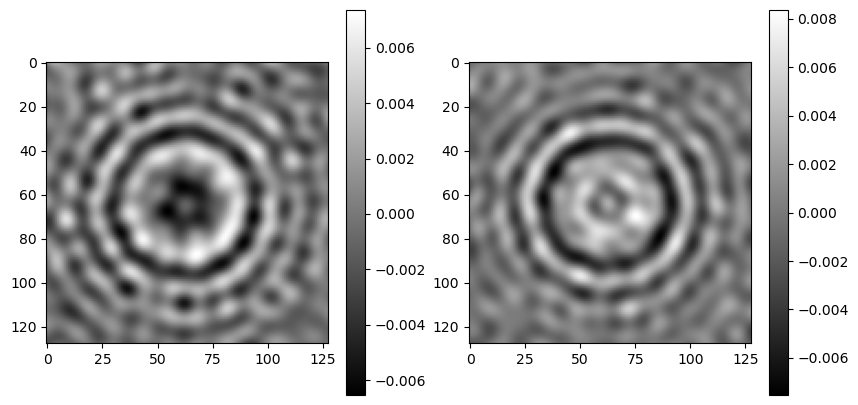

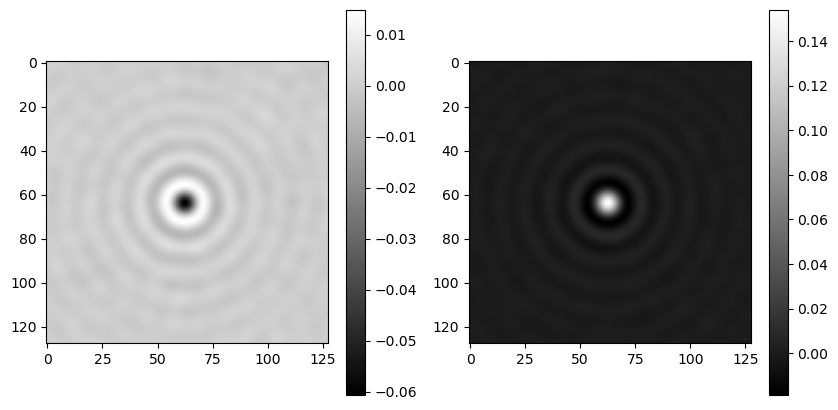

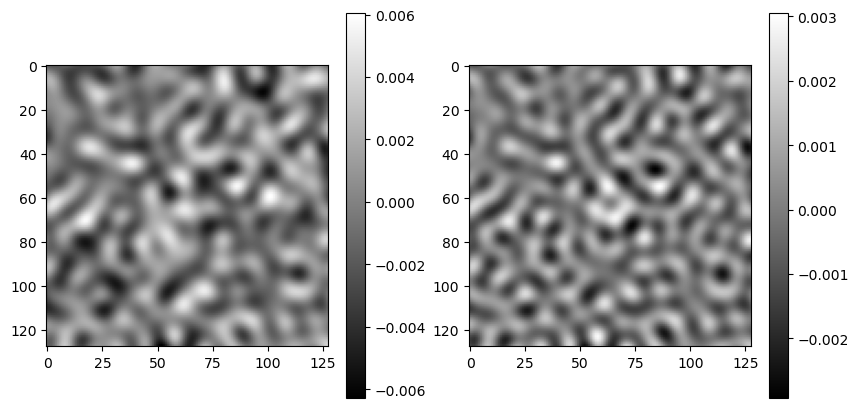

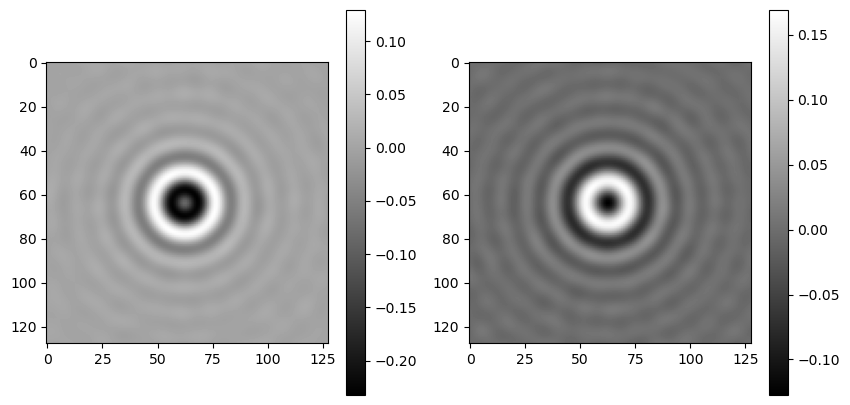

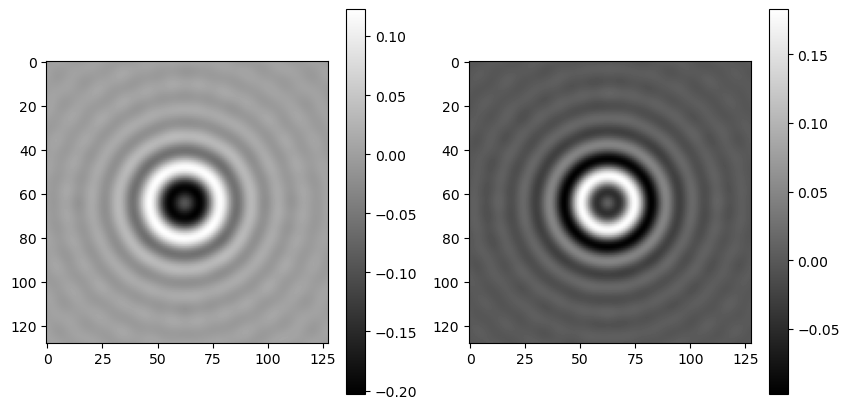

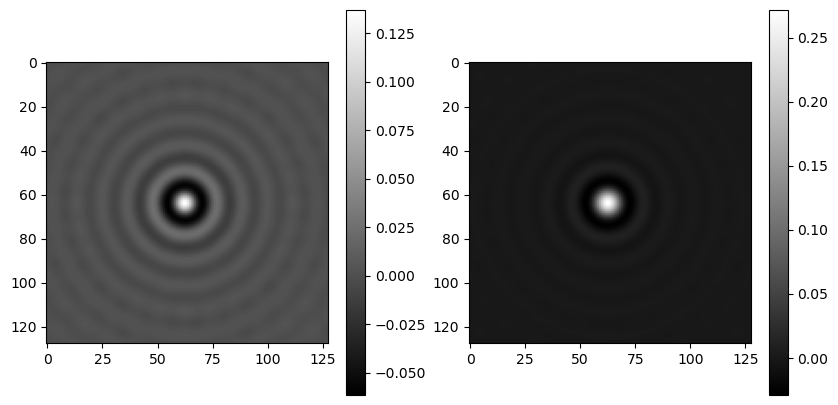

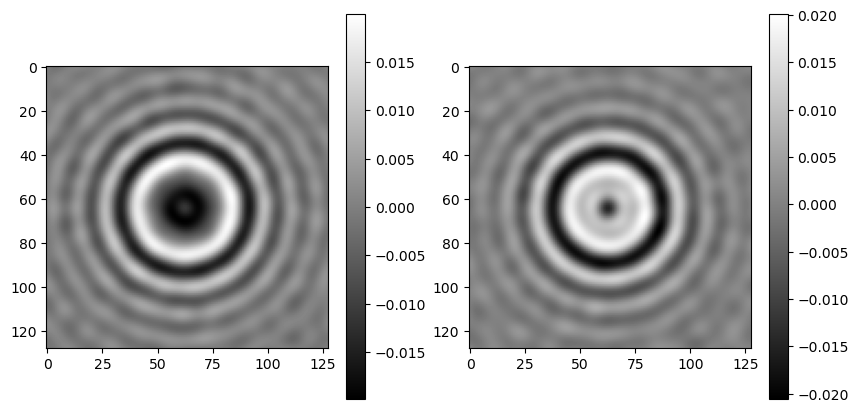

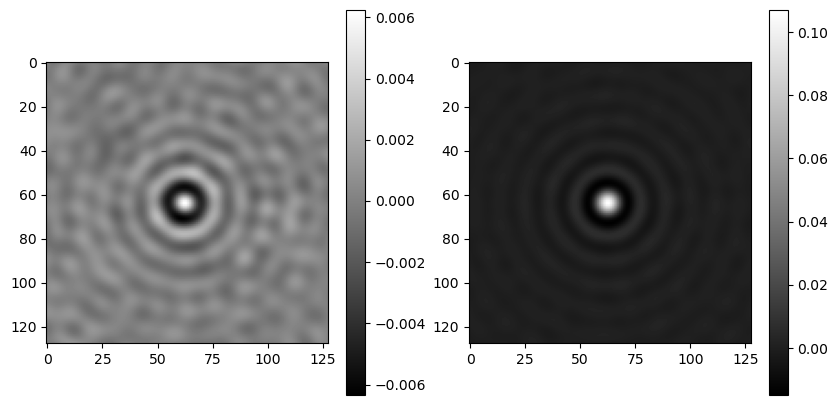

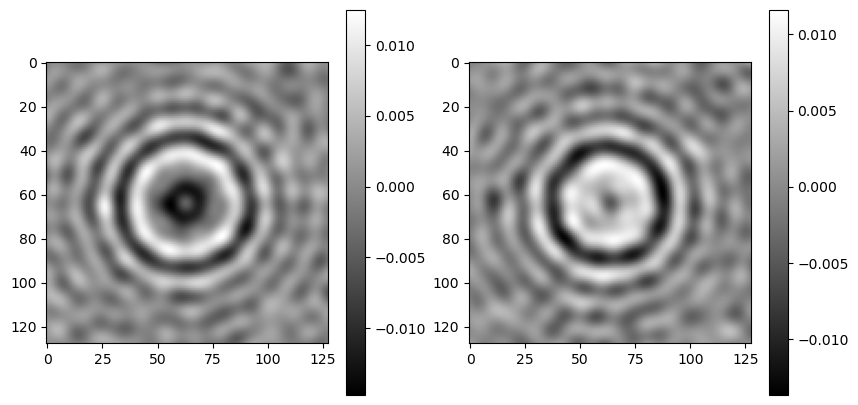

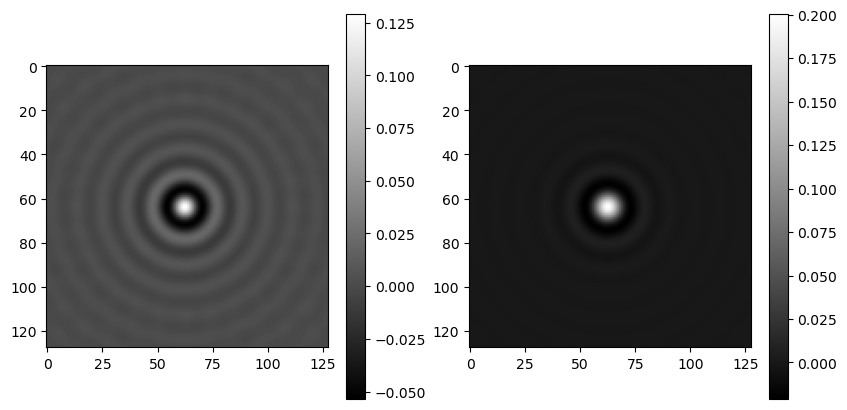

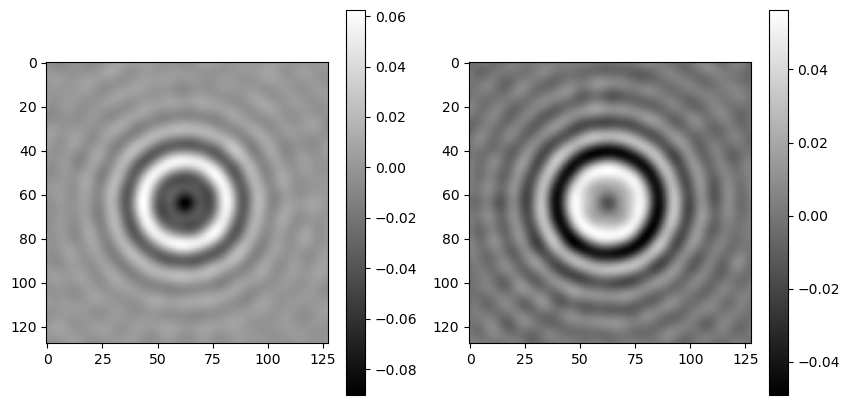

In [56]:
for i in range(16):
    dataset.update()
    image_of_particle = dataset.resolve()

    plt.figure(figsize = (10, 5))
    
    plt.subplot(1,2,1)
    plt.imshow(image_of_particle[:, :, 0], cmap = 'gray')
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(image_of_particle[:, :, 1], cmap = 'gray')
    plt.colorbar()
    
    plt.show()

### 2. Network design

In [57]:
def get_label(image):
    z = (image.get_property('z') + SAMPLE_THICKNESS / 2) / SAMPLE_THICKNESS
    return z

In [58]:
import keras.backend as K
import keras.optimizers as optimizers

model = dt.models.Convolutional(
    input_shape= (IMAGE_SIZE, IMAGE_SIZE, 2),
    conv_layers_dimensions= (32, 64, 64, 64, 128),
    dense_layers_dimensions= (128, 64, 32, 16),
    steps_per_pooling= 2,
    number_of_outputs= 1,
    dropout= (.2, .2),
    loss= 'mae',
    optimizer= 'adam',
    dense_block= dt.layers.DenseBlock(activation='relu')
)

model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 2)]     0         
                                                                 
 conv2d_30 (Conv2D)          (None, 128, 128, 32)      608       
                                                                 
 activation_42 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 conv2d_31 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 activation_43 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 spatial_dropout2d_6 (Spatia  (None, 128, 128, 32)     0         
 lDropout2D)                                                     
                                                          

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

validation_set_size = 256
validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

In [60]:
generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    min_data_size= int(512),
    max_data_size= int(2e3),
    batch_size= 64
)

totalhistory = {"training_loss": [], "validation_loss": [], "epoch": [], "validation_predictions": []}

In [61]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    EPOCHS_BETWEEN_PLOTS = 10000
    EPOCHS_TO_TRAIN = EPOCHS_BETWEEN_PLOTS

    for i in range(0, EPOCHS_TO_TRAIN, EPOCHS_BETWEEN_PLOTS):
        with generator:
            h = model.fit(
                generator,
                validation_data= (np.array(validation_set), np.array(validation_labels)),
                epochs= EPOCHS_BETWEEN_PLOTS
            )

        totalhistory["validation_loss"].extend(h.history["val_loss"])
        totalhistory["training_loss"].extend(h.history["loss"])
        totalhistory["epoch"].extend(list(range(i, i+EPOCHS_BETWEEN_PLOTS)))
        totalhistory["validation_predictions"].append(model.predict(np.array(validation_set)))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
        
        ax1.plot(totalhistory["epoch"], totalhistory["training_loss"], 'g', label = "Training")
        ax1.plot(totalhistory["epoch"], totalhistory["validation_loss"], 'b', label = "Validation")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.legend()

        ax2.plot(totalhistory["validation_predictions"][i], validation_labels, '.')
        ax2.plot(
            np.linspace(0, 1),
            np.linspace(0, 1),
            'k--')
        ax2.set_xlabel("Predicted z [relative]")
        ax2.set_ylabel("True z [relative]")

        plt.show()
else:
    import keras
    model = keras.models.load_model("my_model")


Generating 518 / 512 samples before starting training
Epoch 1/10000
8/8 [==============================] - 19s 2s/step - loss: 0.3741 - val_loss: 0.2999
Epoch 2/10000
8/8 [==============================] - 18s 2s/step - loss: 0.2637 - val_loss: 0.2488
Epoch 3/10000
8/8 [==============================] - 20s 3s/step - loss: 0.2532 - val_loss: 0.2481
Epoch 4/10000
8/8 [==============================] - 18s 2s/step - loss: 0.2553 - val_loss: 0.2475
Epoch 5/10000
8/8 [==============================] - 18s 2s/step - loss: 0.2592 - val_loss: 0.2479
Epoch 6/10000
8/8 [==============================] - 18s 2s/step - loss: 0.2427 - val_loss: 0.2478
Epoch 7/10000
8/8 [==============================] - 18s 2s/step - loss: 0.2501 - val_loss: 0.2487
Epoch 8/10000
8/8 [==============================] - 18s 2s/step - loss: 0.2501 - val_loss: 0.2456
Epoch 9/10000
8/8 [==============================] - 18s 2s/step - loss: 0.2407 - val_loss: 0.2488
Epoch 10/10000
8/8 [==============================] - 1

KeyboardInterrupt: 

In [ ]:
import matplotlib.animation as animation

figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

x = np.linspace(0,1)

ax2.plot(x, x, 'k--')

def animate(i):
    ax1.clear()
    ax1.plot(totalhistory["epoch"][:i], totalhistory["training_loss"][:i], 'g', label = "Training")
    ax1.plot(totalhistory["epoch"][:i], totalhistory["validation_loss"][:i], 'b', label = "Validation")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    #if i == 0:
    #    ax1.legend()

    ax2.clear()
    ax2.set_xlabel("Predicted z")
    ax2.plot(x, x, 'k--')
    ax2.scatter(totalhistory["validation_predictions"][i], validation_labels)

myAnimation = animation.FuncAnimation(figure, animate, frames= len(totalhistory["validation_predictions"]), interval= 150)
myAnimation.save("mymovie.mp4")

## Visualizing featuremaps

In [244]:
for layer in model.layers:
    if 'conv' not in layer.name:
        continue

    filters, biases = layer.get_weights()
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    print(layer.name, filters.shape)

    n_filters, ix = 6, 1
    for i in range(n_filters):
        f = filters[:, :, :, i]
        n_chanels = 2
        for j in range(n_chanels): # TODO: why not 3?
            ax = plt.subplot(n_filters, n_chanels, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(f[:, :, j], cmap='gray')
            ix += 1
    plt.show()

conv2d_6 (3, 3, 2, 32)


AttributeError: 'AxesSubplot' object has no property 'figsize'

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]

    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)
    

1 conv2d (None, 64, 64, 32)
3 conv2d_1 (None, 64, 64, 32)
7 conv2d_2 (None, 32, 32, 64)
9 conv2d_3 (None, 32, 32, 64)
13 conv2d_4 (None, 16, 16, 128)
15 conv2d_5 (None, 16, 16, 128)


[[0.8941585]]
0.9124181944557382


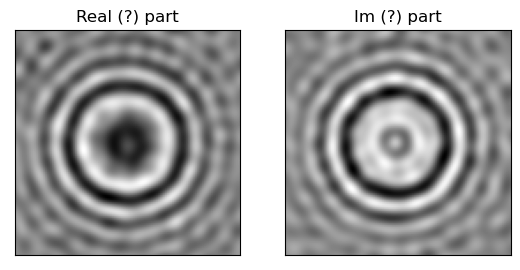

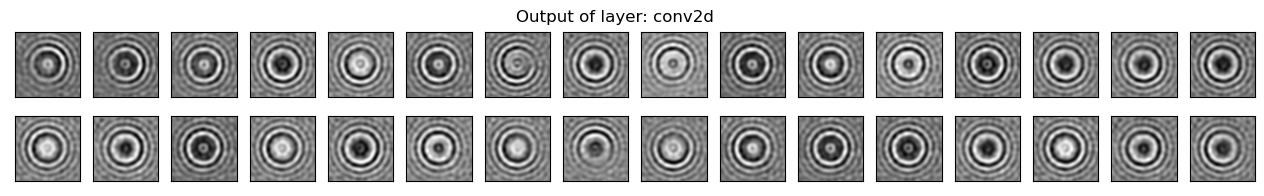

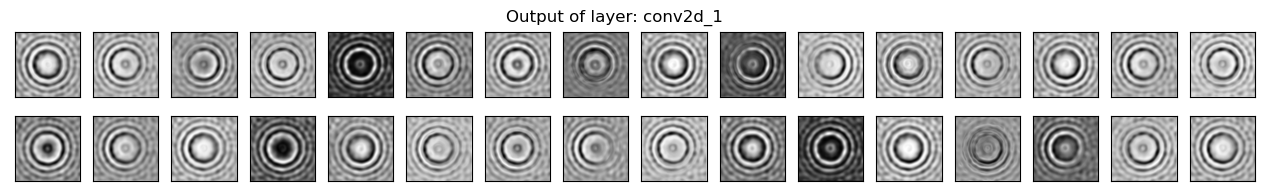

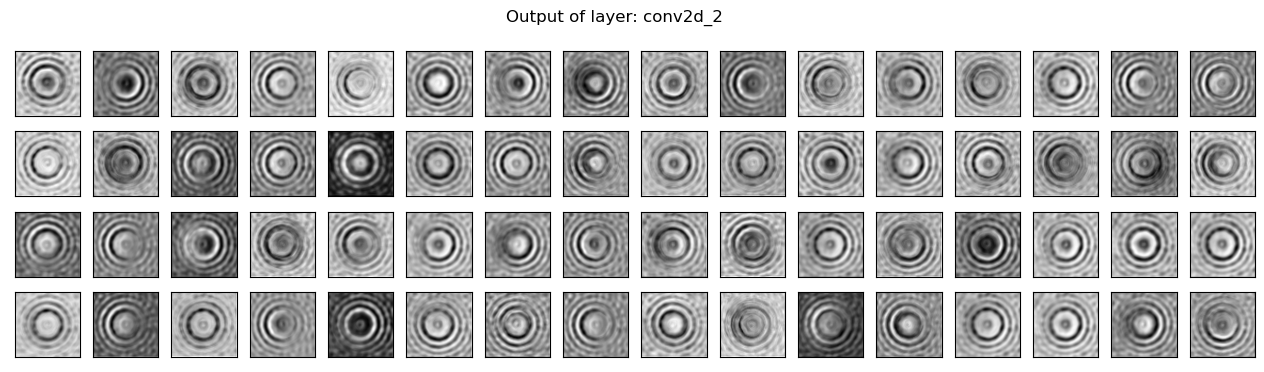

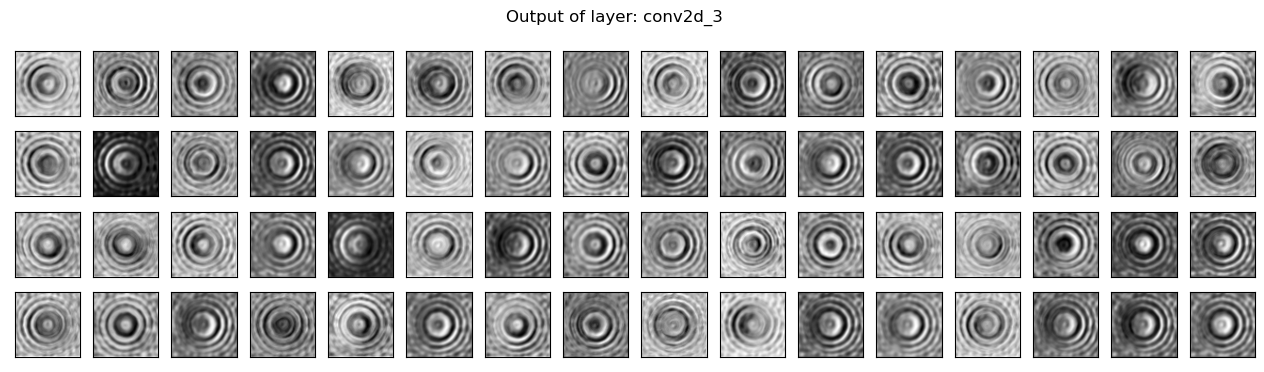

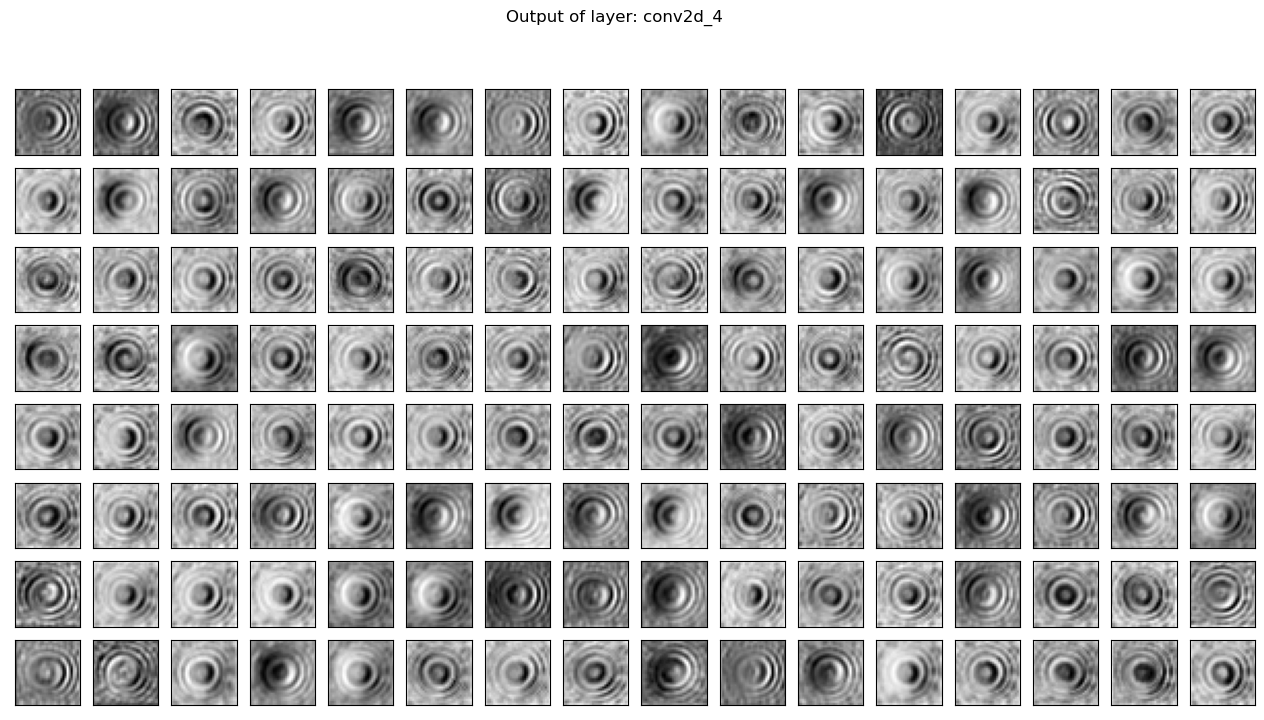

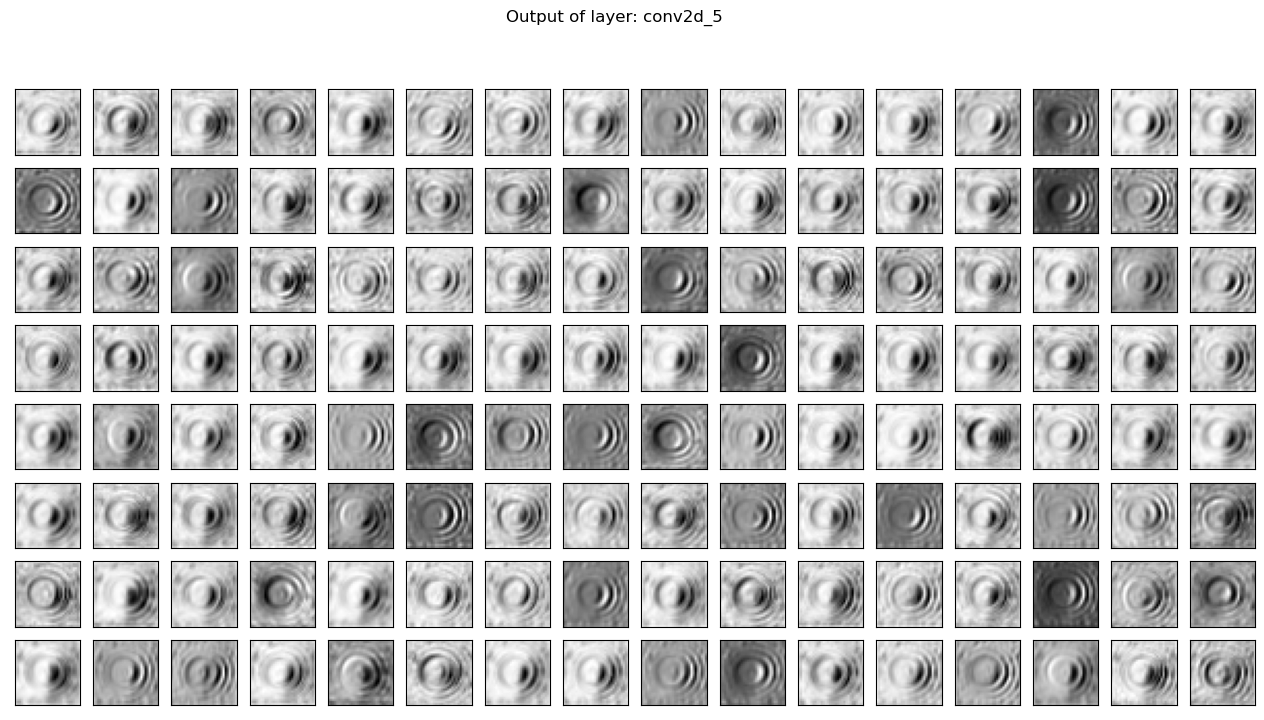

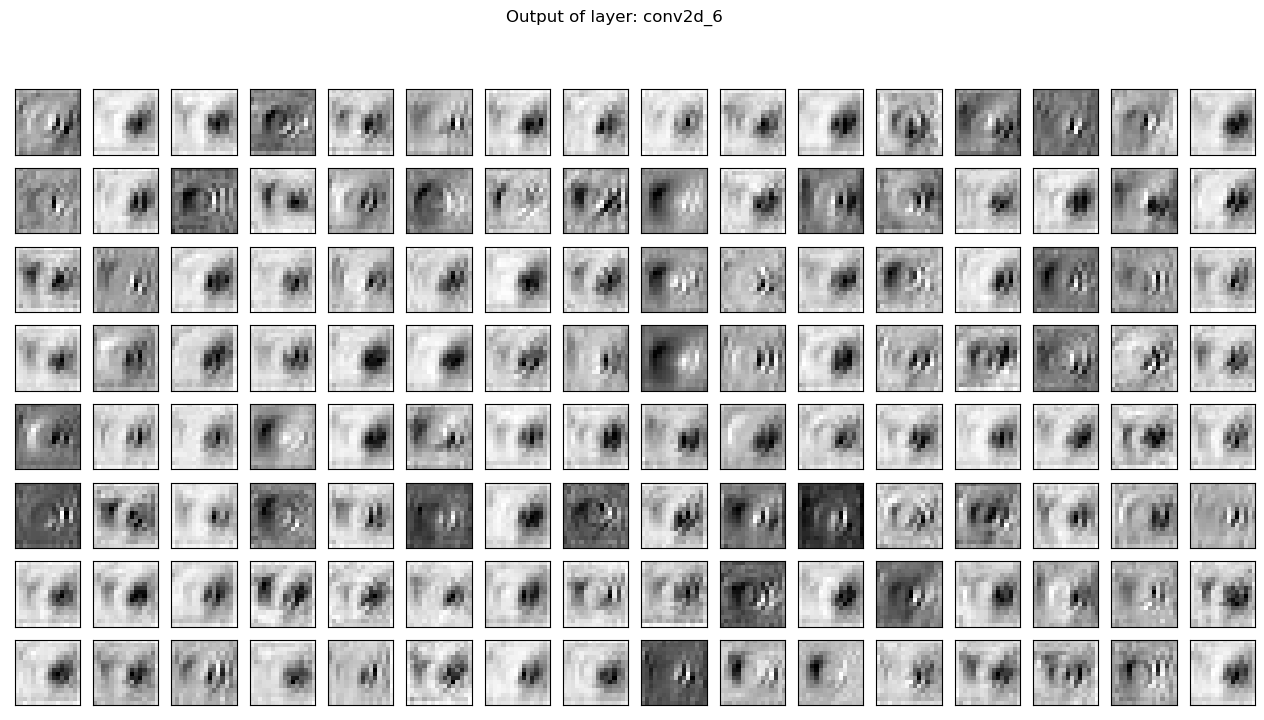

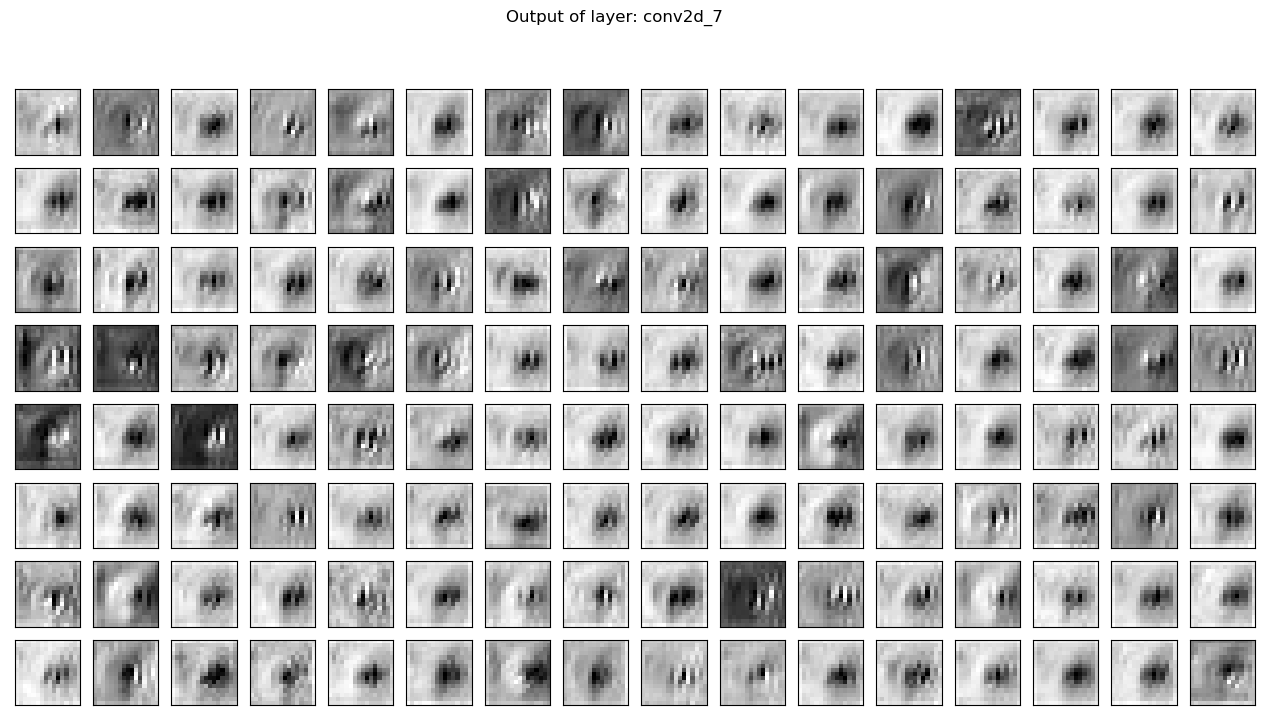

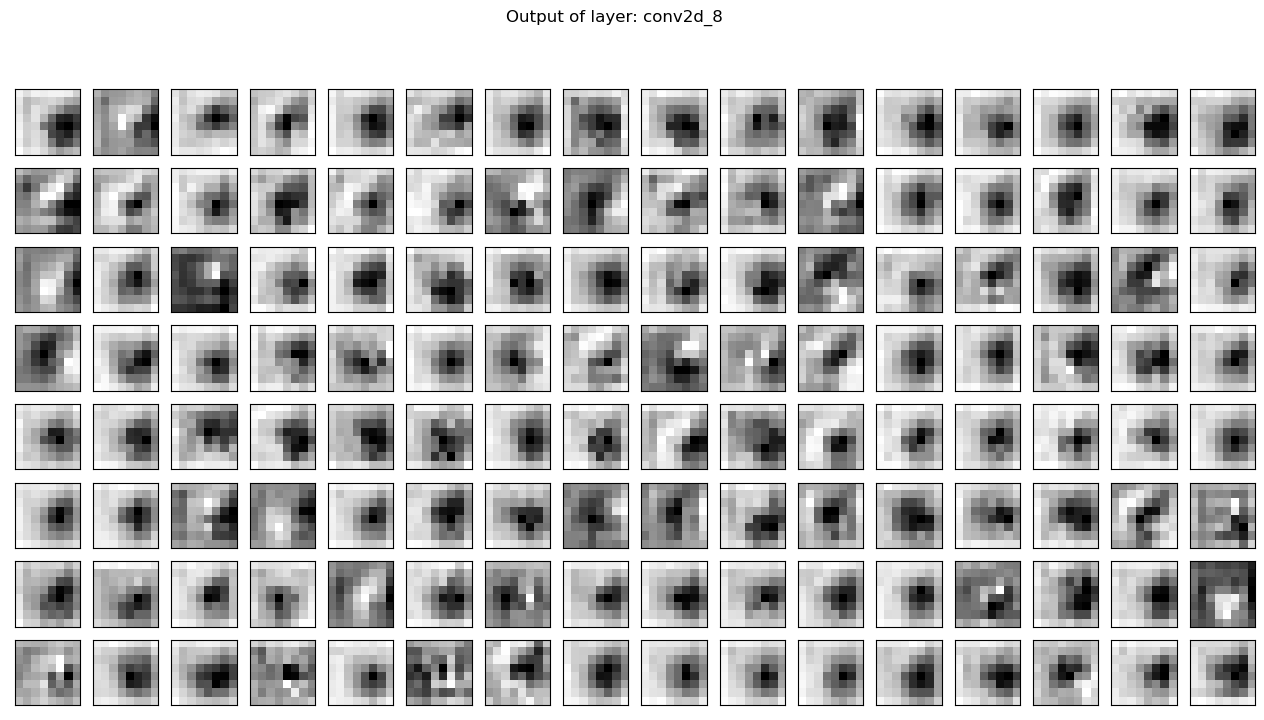

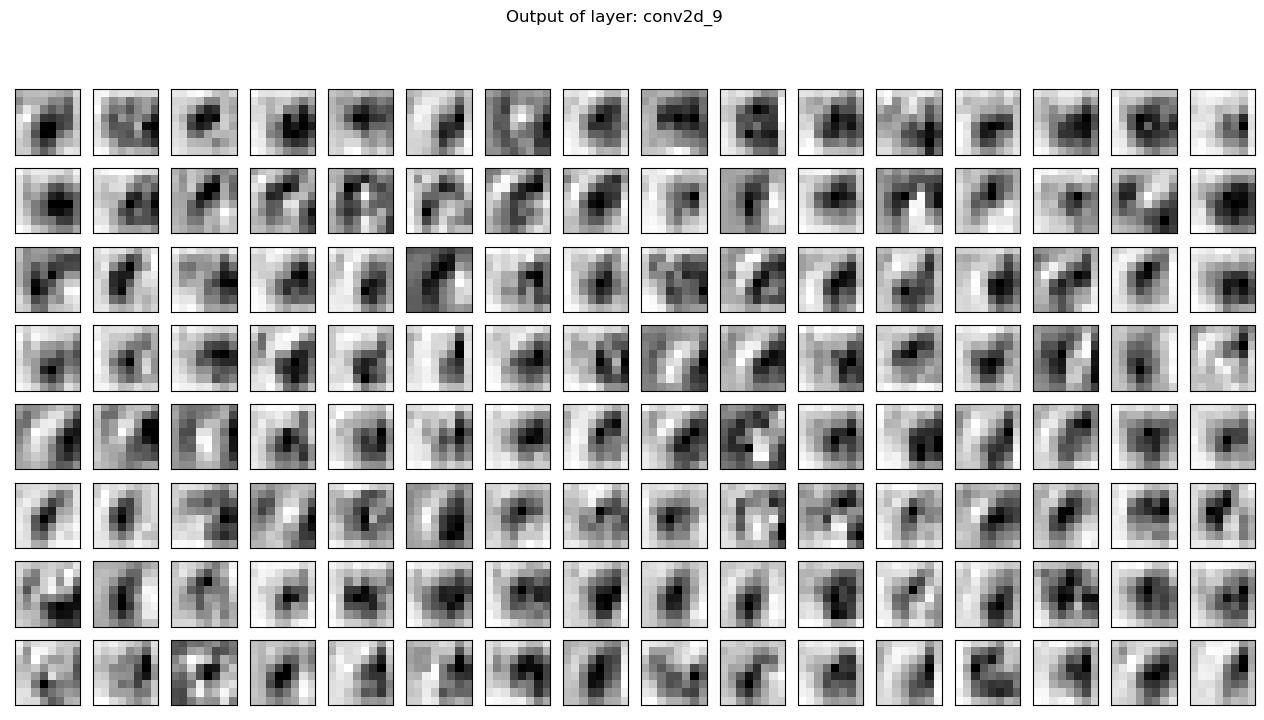

In [73]:
import visualize_feature_maps as vs
import keras

model = keras.models.load_model("sick_gpu_trained_killer_model")

dataset.update()
image_of_particle = dataset.resolve()
print(model.predict(image_of_particle.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 2)))
print(get_label(image_of_particle))
vs.visualize_feature_maps(model, image_of_particle, SUBPLOT_WIDTH=16, SUBPLOT_SIZE=1)